# Inference and analysis of cell-cell communication using CellAgentChat with pseudotime

This tutorial provides a step-by-step guide on performing inference, analysis, and visualization of a cell-cell communication network for a single dataset using CellAgentChat's pseudotime mode. We demonstrate the diverse capabilities of CellAgentChat by applying it to scRNA-seq data obtained from cells of human squamous cell carcinoma patients.

CellAgentChat relies on user-provided gene expression data of cells and utilizes prior knowledge of signaling ligand-receptor interactions to model the probability of cell-cell communication. In this tutorial, we also showcase the incorporation of spatial transcriptomics data, which allows the model to consider the spatial proximity between cells when calculating cell-cell communication. Here, we also calculate the pseudotime trajectory of cells and include this knowledge to model the probability of cell-cell communication.

CellAgentchat also provides an animation framework to view the interaction receiving strength of individual cells in real time. Once the intercellular communication network is inferred, CellAgentChat offers additional functionality for exploring, analyzing, and visualizing the data.

### Load Packages

In [1]:
from preprocessor import *
from trajectory import *
import model_setup
from model_setup import *
import scanpy as sc
import permutations
from permutations import *
import communication_pseudotime
from communication_pseudotime import *
import abm_pseudotime
from abm_pseudotime import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Part 1: Data input, processing and initialization

### Load Input Files

CellAgentChat requires two inputs: one is the gene expression data of cells, and the other is user assigned cell labels (i.e cell types/clusters). Optionally, the user can supply the spatial coordinates of cells, the pseudotime trajectory of cell (see pseudotime tutorial) and x_umap (optional, used for plotting). 

Here, the pseudotime information for each cell is not provided, and we will instead compute it during the following steps.

In [2]:
gene_expression = pd.read_csv('gene_expression.csv', index_col='cell')
meta = pd.read_csv('meta.csv', index_col='cell')

#optional
spatial = pd.read_csv('spatial_coordinates.csv', index_col='cell')
x_umap = pd.read_csv('x_umap.csv', index_col='cell') #for plotting

### Create anndata object

Create anndata object from input files. If no spatial information is available set ```coordinates = None```. If no pseudotime information available set ```pseudotime = None```

In [3]:
adata = create_anndata(gene_expression=gene_expression, meta=meta, x_umap=x_umap, coordinates=spatial, pseudotime=None)

### Preprocess data

Normalized data (e.g., cells and gene filtered, library-size normalization and then log-transformed with a pseudocount of 1) is required as input for CellAgentChat analysis. If user provides count data, we provide an ```expression_processor``` function.

In [4]:
adata = expression_processor(adata, normalize = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Plot spatial coordinates

Plot the spatial coordinates of each cell. Requires the ```x_umap``` input. 

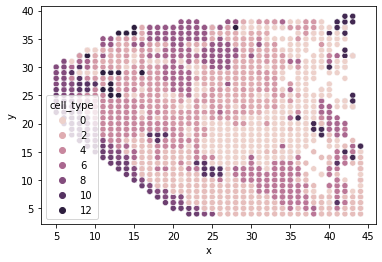

In [5]:
plot_spatial(adata)

### Calculate pseudotime

To calculate the pseudotime values of each cell, we manually using a python implementation of Slingshot. The values are saved to file given in ```file``` argument and added to our anndata object

/Users/vraghavan/Desktop/CellAgentChat/trajectory.py:13: RuntimeWarning: divide by zero encountered in log
  return np.multiply(p, np.log(p)/np.log(N))
/Users/vraghavan/Desktop/CellAgentChat/trajectory.py:13: RuntimeWarning: invalid value encountered in multiply
  return np.multiply(p, np.log(p)/np.log(N))


Lineages: [Lineage[9, 8, 4, 0, 6, 11, 10], Lineage[9, 8, 4, 0, 3, 2, 7], Lineage[9, 8, 4, 0, 3, 12], Lineage[9, 8, 4, 1, 5]]


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @3 with lineages: [1, 2] [<pcurve.pcurve.PrincipalCurve object at 0x28ae0a4a0>, <pcurve.pcurve.PrincipalCurve object at 0x28ae0a440>]
Averaging branch @0 with lineages: [0, 1, 2] [<pcurve.pcurve.PrincipalCurve object at 0x28ae44340>, <pcurve.pcurve.PrincipalCurve object at 0x28cc0f550>]
Averaging branch @4 with lineages: [0, 1, 2, 3] [<pcurve.pcurve.PrincipalCurve object at 0x28ae0a530>, <pcurve.pcurve.PrincipalCurve object at 0x28ae0b160>]
Shrinking branch @4 with curves: [<pcurve.pcurve.PrincipalCurve object at 0x28ae0a530>, <pcurve.pcurve.PrincipalCurve object at 0x28ae0b160>]
Shrinking branch @0 with curves: [<pcurve.pcurve.PrincipalCurve object at 0x28ae44340>, <pcurve.pcurve.PrincipalCurve object at 0x28cc0f550>]
Shrinking branch @3 with curves: [<pcurve.pcurve.PrincipalCurve object at 0x28ae0a4a0>, <pcurve.pcurve.PrincipalCurve object at 0x28ae0a440>]


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


[16.66432274 11.02534596 10.10503717 ... 14.25835799  9.77845557
  6.52986423]
pseudotime values saved to pseudotime.csv


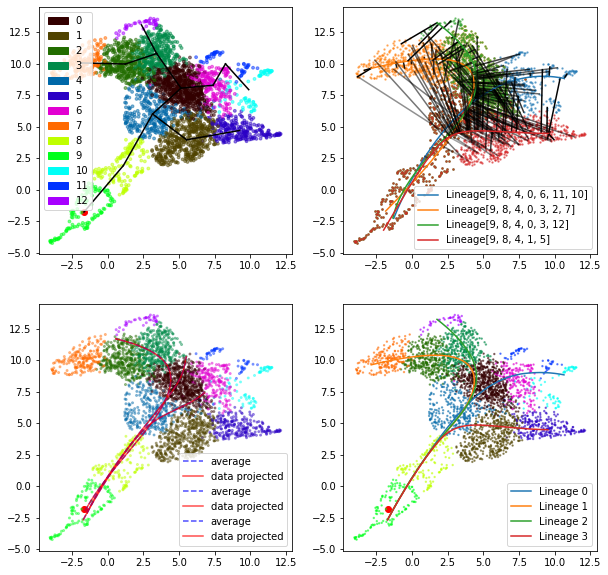

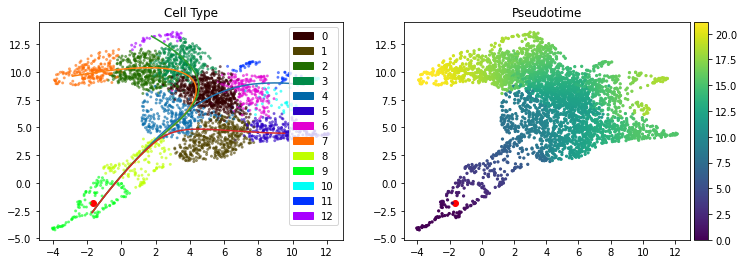

In [6]:
get_trajectory(adata)
adata = add_pseudotime(adata, file='pseudotime.csv')

## Part 2: Model Setup

### Loading Database

The default database is derived from CellTalkDB which is a manually curated database of literature-supported ligand-receptor interactions in humans. CellTalkDB contains over 3400 validated molecular human interactions.

Users can upload their own database file with curated ligand-receptor pairs.

In [7]:
lig_uni, rec_uni = load_db(adata, file = 'human_lr_pair.tsv')

Loading Database...
Database Loaded!


### Deep Learning Model to estimate downstream expression

Setup and train neural network. The neural network takes as input a vector vr<sub>i</sub> representing expression of all receptors in cell i. This receptor expression vector is then fed into the neural network (F) to predict the expression x<sub>i</sub>  of all genes in cell i (regression task). The neural network structure was composed the following components: one input layer, one hidden layer, and output layer. The input layer is of size equivalent to the number of receptors. The output layer is the same size as the number of all genes. The hidden layer is of size one thousand representing transcription factors involved in downstream signaling pathways.

The model is saved to the path provided in the ```path``` argument.

In [8]:
mat, C = train(adata, rec_uni, "model.pt")

Setting up model
Training model
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19
epoch: 20
epoch: 21
epoch: 22
epoch: 23
epoch: 24
epoch: 25
epoch: 26
epoch: 27
epoch: 28
epoch: 29
epoch: 30
epoch: 31
epoch: 32
epoch: 33
epoch: 34
epoch: 35
epoch: 36
epoch: 37
epoch: 38
epoch: 39
epoch: 40
epoch: 41
epoch: 42
epoch: 43
epoch: 44
epoch: 45
epoch: 46
epoch: 47
epoch: 48
epoch: 49


Load deep learning model

In [9]:
model_dl = load_model("model.pt")

### Caculate conversion rates for each receptor

With the trained neural network regressor, we then perform sensitivity analysis to score each input receptor based on how much impact it imposes on the downstream gene expression. This is known as the conversion rate for a receptor. 

In [10]:
conversion_rates = feature_selection(model_dl, mat, C, rec_uni)

Performing feature selection to obtain conversion rates
receptor: 0
receptor: 1
receptor: 2
receptor: 3
receptor: 4
receptor: 5
receptor: 6
receptor: 7
receptor: 8
receptor: 9
receptor: 10
receptor: 11
receptor: 12
receptor: 13
receptor: 14
receptor: 15
receptor: 16
receptor: 17
receptor: 18
receptor: 19
receptor: 20
receptor: 21
receptor: 22
receptor: 23
receptor: 24
receptor: 25
receptor: 26
receptor: 27
receptor: 28
receptor: 29
receptor: 30
receptor: 31
receptor: 32
receptor: 33
receptor: 34
receptor: 35
receptor: 36
receptor: 37
receptor: 38
receptor: 39
receptor: 40
receptor: 41
receptor: 42
receptor: 43
receptor: 44
receptor: 45
receptor: 46
receptor: 47
receptor: 48
receptor: 49
receptor: 50
receptor: 51
receptor: 52
receptor: 53
receptor: 54
receptor: 55
receptor: 56
receptor: 57
receptor: 58
receptor: 59
receptor: 60
receptor: 61
receptor: 62
receptor: 63
receptor: 64
receptor: 65
receptor: 66
receptor: 67
receptor: 68
receptor: 69
receptor: 70
receptor: 71
receptor: 72
recep

Save conversion rates

In [11]:
save_conversion_rate(conversion_rates)

Done


Load conversion rates

In [12]:
conversion_rates = load_conversion_rate()
rates = add_rates(conversion_rates, rec_uni)

Conversion rates loaded


### Background Distribution

We employed a random permutation test to calculate the statistical significance p-value associated with each ligand-receptor interaction score. The significant interactions between two cell groups are identified using a permutation test by randomly permuting the group labels of cells and then recalculating the interaction score for each ligand receptor. After each permutation the ligand-receptor score is stored regardless of what cell type pair it came from. 

The ```threshold``` argument sets the minimum number of score values needed on average for each ligand-receptor pair.  

```dist=True```  specifies that we want to consider the spatial coordinates of cells when infering cellular interaction. This leads to the calculation of the average distance between cells, which will be used in the subsequent steps. When spatial information is not provided ```dist=False``` should be set. 

```N``` specifies the number of cells to include in the calculation. By defualt all the cells are included, but the suer can specify to use less. 

In [13]:
test_scores, model2, distance = permutation_test_pseudotime(threshold = 10000, N=3295, adata=adata, lig_uni=lig_uni,
                         rec_uni=rec_uni, rates=rates, dist=True, bins=10)


iteration: 1
Average Distance: 17.09968921592907
iteration: 2
Average Distance: 17.09968921592907
iteration: 3
Average Distance: 17.09968921592907
iteration: 4
Average Distance: 17.09968921592907
iteration: 5
Average Distance: 17.09968921592907
iteration: 6
Average Distance: 17.09968921592907
iteration: 7
Average Distance: 17.09968921592907
iteration: 8
Average Distance: 17.09968921592907
iteration: 9
Average Distance: 17.09968921592907
iteration: 10
Average Distance: 17.09968921592907
iteration: 11
Average Distance: 17.09968921592907
iteration: 12
Average Distance: 17.09968921592907
iteration: 13
Average Distance: 17.09968921592907
iteration: 14
Average Distance: 17.09968921592907
iteration: 15
Average Distance: 17.09968921592907
iteration: 16
Average Distance: 17.09968921592907
iteration: 17
Average Distance: 17.09968921592907
iteration: 18
Average Distance: 17.09968921592907
iteration: 19
Average Distance: 17.09968921592907
iteration: 20
Average Distance: 17.09968921592907
iteration

The average distance between all cells

In [14]:
distance

17.09968921592907

For each ligand-receptor pair, we fit the random score distribution with a gamma distribution. By fitting the observed interaction scores (for a specific Ligand-Receptor) pair to a Gamma distribution, we get the estimated parameters (alpha and scale) of the gamma distribution to represent the random interaction score distribution of the Ligand-Receptor pair. 

Since we are including pseudotime in our calculations pseudotime mode must be turned on ```pseudotime = True```.

Note: The scaling feature determined by the argument ```scale``` is not applicable for pseudotime mode.

In [15]:
params = get_distribution(test_scores, pseudotime=True)

Getting background distribution for each ligand-receptor pair


Save the background distribution for each ligand to the given path

In [16]:
save_distribution(params, path='distribution_spatial_pt.csv')

Distribution Saved


Load the background distribution for each ligand to the given path

In [17]:
params = load_distribution('distribution_spatial_pt.csv')

Distribution loaded


### Get choices

When inferring cell communication, the following three lists are used to track specific receptors, ligand-receptor pairs, or cell types:

```proteins``` contains all the receptors in database. 

```pairs``` contains all the ligand-receptor pairs in the database. 

```clusters``` contains all the cell types/clusters present in the dataset. 

In [18]:
proteins = get_protein_choices(rec_uni)
pairs = get_lr_choices(rec_uni, lig_uni)
clusters = get_cluster_choices(adata)

## Part 3: Inference of cell-cell communication network

We provide a function ```CCI``` calculate cell-cell interactions. 

Optional Parameters:

```delta```: Influences the degree of cell-to-cell distance. For long-range mode, a delta value less than 1 is used. This promotes interactions over long distance ranges. While for short-range mode, a delta value greater than 1 is employed, promoting interactions over closer distance ranges [1].

```bins```: The number of bins, which to group cells of each cluster based on their pseudotime value. Cells will only interact with those in the same bin. The number of bins is also the maximum steps of the model.

```shift```: The degree of which to shift the bins [0].

```tau```: The degree of the freedom for the distance [2].

```noise```: Percentage of gaussian noise applied to the ligand diffusion rate at each step [5]

```rec_block```: Receptor to be obstructed by in-silico receptor blocking. Interactions involving the chosen receptor will not occur [False].

```path```: output path/directory [/out].

```interaction_matrix```: Name of the interaction_matrix results file [interaction_matrix.csv].

```sig_lr_pair```: Name of the file consisting of all the inferred cell-cell communications at the level of ligands/receptors [sig_lr_pair.csv].

```pvalues_name```: Name of the file consisting of the pvalues for the interactions that correspond to the ```sig_lr_pair``` file [pvalues.csv]. 

```pvalues2_names```: Name of the file consisting of the pvalue group (0.05 < p < 0.025, 0.025< p < 0.01, p < 0.01) for the interactions that correspond to the ```sig_lr_pair``` file [pvalues2.csv]. 

```cluster_name```: Name of the file that stores the list of cell types(for plotting) [cluster_names.csv].

In [19]:
CCI_pseudotime(N=len(adata.obs), adata=adata, lig_uni=lig_uni, rec_uni=rec_uni, 
               rates=rates, distribution=params, clusters=clusters, bins=10, dist=True)

Calculating Interactions
Average Distance: 17.09968921592907
Calculating Significant Interactions
792 significant interactions
Percentage of significant interactions: 0.43044881898322773
Saving Files
Saved files
Plotting results
null device 
          1 


Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead. 
Warning message:
Using size for a discrete variable is not advised. 


Plots saved


All result files and plots saved in the ```path``` directory path. 

## Part 4: Animation platform

Model parameters described in part 3

In [20]:
model_params = abm_pseudotime.parameters(adata, lig_uni, rec_uni, rates, clusters, pairs, proteins)

Call the animation platform. This will produce a popup to the animation server. If not considering spatial information ```dist_on``` must be set to ```False```. Otherwise ```dist_on=True```. 

Note: The animation platform needs to be re opened with a different ```port``` number at every use (as long as the saem jupyter notebook file is open).  

In [ ]:
abm_pseudotime.visualization(adata, model_params, dist_on=True, port=8533)